<a href="https://colab.research.google.com/github/abhilash1910/Accelerated_Deep_Learning/blob/master/SIMD_SingleMachine_ModelParallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__config__.show().split("\n"), sep="\n")

['PyTorch built with:', '  - GCC 7.3', '  - C++ Version: 201402', '  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications', '  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)', '  - OpenMP 201511 (a.k.a. OpenMP 4.5)', '  - LAPACK is enabled (usually provided by MKL)', '  - NNPACK is enabled', '  - CPU capability usage: AVX2', '  - CUDA Runtime 11.3', '  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86', '  - CuDNN 8.2', '  - Magma 2.5.2', '  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBU

In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Fri Jun 17 18:17:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [5]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Core Bottleneck Resnet from Lucidrains

import math
import torch
from torch import nn, einsum

from einops import rearrange


def pair(x):
    return (x, x) if not isinstance(x, tuple) else x

def expand_dim(t, dim, k):
    t = t.unsqueeze(dim = dim)
    expand_shape = [-1] * len(t.shape)
    expand_shape[dim] = k
    return t.expand(*expand_shape)

def rel_to_abs(x):
    b, h, l, _, device, dtype = *x.shape, x.device, x.dtype
    dd = {'device': device, 'dtype': dtype}
    col_pad = torch.zeros((b, h, l, 1), **dd)
    x = torch.cat((x, col_pad), dim = 3)
    flat_x = rearrange(x, 'b h l c -> b h (l c)')
    flat_pad = torch.zeros((b, h, l - 1), **dd)
    flat_x_padded = torch.cat((flat_x, flat_pad), dim = 2)
    final_x = flat_x_padded.reshape(b, h, l + 1, 2 * l - 1)
    final_x = final_x[:, :, :l, (l-1):]
    return final_x

def relative_logits_1d(q, rel_k):
    b, heads, h, w, dim = q.shape
    logits = einsum('b h x y d, r d -> b h x y r', q, rel_k)
    logits = rearrange(logits, 'b h x y r -> b (h x) y r')
    logits = rel_to_abs(logits)
    logits = logits.reshape(b, heads, h, w, w)
    logits = expand_dim(logits, dim = 3, k = h)
    return logits

# positional embeddings

class AbsPosEmb(nn.Module):
    def __init__(
        self,
        fmap_size,
        dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.height = nn.Parameter(torch.randn(height, dim_head) * scale)
        self.width = nn.Parameter(torch.randn(width, dim_head) * scale)

    def forward(self, q):
        emb = rearrange(self.height, 'h d -> h () d') + rearrange(self.width, 'w d -> () w d')
        emb = rearrange(emb, ' h w d -> (h w) d')
        logits = einsum('b h i d, j d -> b h i j', q, emb)
        return logits

class RelPosEmb(nn.Module):
    def __init__(
        self,
        fmap_size,
        dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.fmap_size = fmap_size
        self.rel_height = nn.Parameter(torch.randn(height * 2 - 1, dim_head) * scale)
        self.rel_width = nn.Parameter(torch.randn(width * 2 - 1, dim_head) * scale)

    def forward(self, q):
        h, w = self.fmap_size

        q = rearrange(q, 'b h (x y) d -> b h x y d', x = h, y = w)
        rel_logits_w = relative_logits_1d(q, self.rel_width)
        rel_logits_w = rearrange(rel_logits_w, 'b h x i y j-> b h (x y) (i j)')

        q = rearrange(q, 'b h x y d -> b h y x d')
        rel_logits_h = relative_logits_1d(q, self.rel_height)
        rel_logits_h = rearrange(rel_logits_h, 'b h x i y j -> b h (y x) (j i)')
        return rel_logits_w + rel_logits_h

# classes

class Attention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        fmap_size,
        heads = 4,
        dim_head = 128,
        rel_pos_emb = False
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_qkv = nn.Conv2d(dim, inner_dim * 3, 1, bias = False)

        rel_pos_class = AbsPosEmb if not rel_pos_emb else RelPosEmb
        self.pos_emb = rel_pos_class(fmap_size, dim_head)

    def forward(self, fmap):
        heads, b, c, h, w = self.heads, *fmap.shape

        q, k, v = self.to_qkv(fmap).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h = heads), (q, k, v))

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        sim = sim + self.pos_emb(q)

        attn = sim.softmax(dim = -1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return out

class BottleBlock(nn.Module):
    def __init__(
        self,
        *,
        dim,
        fmap_size,
        dim_out,
        proj_factor,
        downsample,
        heads = 4,
        dim_head = 128,
        rel_pos_emb = False,
        activation = nn.ReLU()
    ):
        super().__init__()

        # shortcut

        if dim != dim_out or downsample:
            kernel_size, stride, padding = (3, 2, 1) if downsample else (1, 1, 0)

            self.shortcut = nn.Sequential(
                nn.Conv2d(dim, dim_out, kernel_size, stride = stride, padding = padding, bias = False),
                nn.BatchNorm2d(dim_out),
                activation
            ).to('cuda:0')
        else:
            self.shortcut = nn.Identity()

        # contraction and expansion

        attn_dim_in = dim_out // proj_factor
        attn_dim_out = heads * dim_head

        self.net = nn.Sequential(
            nn.Conv2d(dim, attn_dim_in, 1, bias = False),
            nn.BatchNorm2d(attn_dim_in),
            activation,
            Attention(
                dim = attn_dim_in,
                fmap_size = fmap_size,
                heads = heads,
                dim_head = dim_head,
                rel_pos_emb = rel_pos_emb
            ),
            nn.AvgPool2d((2, 2)) if downsample else nn.Identity(),
            nn.BatchNorm2d(attn_dim_out),
            activation,
            nn.Conv2d(attn_dim_out, dim_out, 1, bias = False),
            nn.BatchNorm2d(dim_out)
        ).to('cuda:0')

        # init last batch norm gamma to zero

        nn.init.zeros_(self.net[-1].weight)

        # final activation

        self.activation = activation

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.net(x)
        x = x + shortcut
        return self.activation(x)

# main bottle stack

class BottleStack(nn.Module):
    def __init__(
        self,
        *,
        dim,
        fmap_size,
        dim_out = 2048,
        proj_factor = 4,
        num_layers = 3,
        heads = 4,
        dim_head = 128,
        downsample = True,
        rel_pos_emb = False,
        activation = nn.ReLU()
    ):
        super().__init__()
        fmap_size = pair(fmap_size)

        self.dim = dim
        self.fmap_size = fmap_size

        layers = []

        for i in range(num_layers):
            is_first = i == 0
            dim = (dim if is_first else dim_out)
            layer_downsample = is_first and downsample

            fmap_divisor = (2 if downsample and not is_first else 1)
            layer_fmap_size = tuple(map(lambda t: t // fmap_divisor, fmap_size))

            layers.append(BottleBlock(
                dim = dim,
                fmap_size = layer_fmap_size,
                dim_out = dim_out,
                proj_factor = proj_factor,
                heads = heads,
                dim_head = dim_head,
                downsample = layer_downsample,
                rel_pos_emb = rel_pos_emb,
                activation = activation
            ))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        _, c, h, w = x.shape
        assert c == self.dim, f'channels of feature map {c} must match channels given at init {self.dim}'
        assert h == self.fmap_size[0] and w == self.fmap_size[1], f'height and width ({h} {w}) of feature map must match the fmap_size given at init {self.fmap_size}'
        return self.net(x)

In [ ]:

from torchvision.models import resnet50
layer = BottleStack(
    dim = 256,
    fmap_size = 56,        
    dim_out = 2048,
    proj_factor = 4,
    downsample = True,
    heads = 4,
    dim_head = 128,
    rel_pos_emb = True,
    activation = nn.ReLU()
)

resnet = resnet50()

backbone = list(resnet.children())

model = nn.Sequential(
    *backbone[:5],
    layer,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(1),
    nn.Linear(2048, 1000)
).to('cuda:0')
model.cuda()


model

In [18]:
#Model Parallelism communication over GPU-GPU

from torchvision.models.resnet import ResNet, Bottleneck
import torchvision.models as models

num_batches = 3
batch_size = 120
image_w = 128
image_h = 128
num_classes = 1000

#Exploit Simd MP
class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)

        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,

            self.layer1,
            self.layer2
        ).to('cuda:0')

        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:0')
        #can be .to('cuda:i+1')

        self.fc.to('cuda:0')

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:0'))
        #can be .to('cuda:i+1')
        return self.fc(x.view(x.size(0), -1))



def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    one_hot_indices = torch.LongTensor(batch_size).random_(0, num_classes).view(batch_size, 1)

    for _ in range(num_batches):
        # generate random inputs and labels
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        labels = torch.zeros(batch_size, num_classes).scatter_(1, one_hot_indices, 1)

        # run forward pass
        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))

        # run backward pass
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()


In [20]:

import timeit
import numpy as np
num_repeat = 10

stmt = "train(model)"

setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" +"model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)



In [21]:
mp_run_times,rn_run_times

([1.1123716200002036,
  1.1299691829999574,
  1.074116351999919,
  1.0834968939998362,
  1.0637668520000716,
  1.0647426460000133,
  1.0603389860000334,
  1.0544568430000254,
  1.054915813999969,
  1.0527757940001266],
 [1.0462304860000131,
  1.0481395310000607,
  1.0431353330000093,
  1.040988293000055,
  1.0490160489998743,
  1.0621146959999805,
  1.0407168409999485,
  1.042717426000081,
  1.0377378399998634,
  1.0380829649998304])

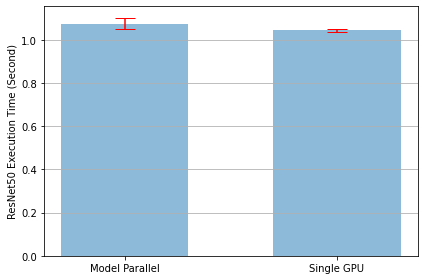

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_name)
    plt.close(fig)


plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

In [27]:
print(mp_mean,rn_mean)
overhead_comms= abs(mp_mean/rn_mean)-1
print(f"{overhead_comms}% time wasted in comms.This will be more for multi tile GPUs ")


1.0750950984000156 1.0448879459999716
0.028909465857734018% time wasted in comms.This will be more for multi tile GPUs 


In [31]:
#Applying distributed data/model parallelism

class DataModelParallelismResNet50(ModelParallelResNet50):
    def __init__(self, split_size, *args, **kwargs):
        super(DataModelParallelismResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        #can be cuda i+1
        s_prev = self.seq1(s_next).to('cuda:0')
        ret = []

        #standard loop /dataloader for iterating on splits
        for s_next in splits:
            # A. s_prev runs on cuda:i+1
            #load prev bytestream to sequential 2 on cuda i+1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:i, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:0')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)
#shard into 120/5 splits 
setup = "model = DataModelParallelismResNet50(5)"
stmt = "train(model)"
dmp_run_times = timeit.repeat( stmt, setup, number=1, repeat=num_repeat, globals=globals())
dmp_mean, dmp_std = np.mean(dmp_run_times), np.std(dmp_run_times)
dmp_mean,dmp_std

(2.87293254160013, 0.19101611091171994)

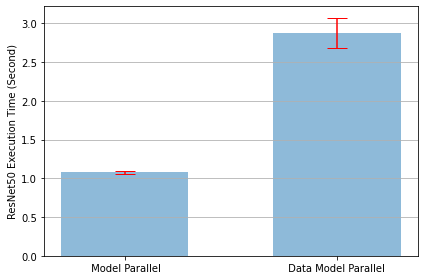

<Figure size 432x288 with 0 Axes>

In [34]:
plot([mp_mean, dmp_mean],
     [mp_std, dmp_std],
     [' Model Parallel', ' Data Model Parallel '],
     'mp_vs_rn.png')



In [35]:
overhead_comms= abs(dmp_mean/mp_mean)-1
print(f"{overhead_comms}% time wasted in dmp comms since we have a single GPU.This will be less for multi tile GPUs ")


1.6722589898100204% time wasted in dmp comms since we have a single GPU.This will be less for multi tile GPUs 
